# Updated Baseline
The code and results below correspond to an upgraded baseline upon the Landslide4Sense dataset. The actual baseline suggested by the dataset was 56% in F1 and 76% in MLou. Here, I replicated the baseline and added my own touches to see how it affects our results.

## Initial Setup and Tests
General focus here is to just get a feel of the data, its dimensions and how we can use for eventual training. Below are cells that:


*   Mount our drive (where the data is located) and initalizes paths.
*   pip install and import all required packages for our baseline.



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_PATH = "/content/drive/MyDrive/LandslideDetection"
DATA_PATH = f"{BASE_PATH}/data"
CHECKPOINT_DIR = f"{BASE_PATH}/outputs"


Mounted at /content/drive


In [2]:
!pip install pandas numpy torch torchvision torchaudio h5py -q
!pip install opencv-python matplotlib segmentation-models-pytorch albumentations tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import os
import cv2
import matplotlib as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import h5py
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data and loading Dataset class
This Section focuses on initializing our .h5 image data. I went through several resources to understand this datatype.

In [4]:
# Test Data and check type, verified it here.

sample_path = f"{DATA_PATH}/TrainData/img/image_1.h5"  # adjust this to match one of your file names

with h5py.File(sample_path, 'r') as f:
    print(list(f.keys()))  # shows all datasets inside the file
    data = f['img'][:]   # try reading the image data (dataset name might be different, we’ll check)
    print("Data shape:", data.shape)

mask_path = f"{DATA_PATH}/TrainData/mask/mask_1.h5"

with h5py.File(mask_path, 'r') as f:
    print(f.keys())  # find correct key
    mask = f['mask'][:]  # or whatever the key is
    print("Mask shape:", mask.shape)
    print("Unique values:", np.unique(mask))


['img']
Data shape: (128, 128, 14)
<KeysViewHDF5 ['mask']>
Mask shape: (128, 128)
Unique values: [0 1]


In [5]:
class LandSlideHSDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, mask_paths, bands=None, transform=None):
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.bands      = bands if bands is not None else list(range(14))
        self.transform  = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        with h5py.File(self.img_paths[idx], 'r') as f:
            img = f['img'][:]                  # (H, W, 14)
        img = img[:, :, self.bands]             # pick channels
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img_tensor = torch.from_numpy(img)

        with h5py.File(self.mask_paths[idx], 'r') as f:
            m = f['mask'][:]                   # (H, W)
        mask = torch.from_numpy(m.astype(np.float32)).unsqueeze(0)

        return img_tensor, mask

In [6]:
import glob
# Use Dataloaders and split the Training data into a 80/20 Split.

img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"
all_img_paths = sorted(glob.glob(f"{img_dir}/*.h5"))
all_mask_paths= sorted(glob.glob(f"{mask_dir}/*.h5"))

from sklearn.model_selection import train_test_split
img_train, img_val, mask_train, mask_val = train_test_split(
    all_img_paths, all_mask_paths, test_size=0.2, random_state=42
)

## Model Initialization

i initialize and set up the loss, network and optimizer here.

In [7]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

# Cell 4: Factory to build model+loss+opt for any in_channels
import segmentation_models_pytorch as smp
import torch.nn as nn

def make_model(in_ch):
    model = smp.Unet(encoder_name='resnet34',
                     in_channels=in_ch,
                     classes=1, activation=None).to(device)
    bce  = nn.BCEWithLogitsLoss()
    dice = smp.losses.DiceLoss(mode='binary')
    def loss_fn(logits, targets):
        return bce(logits, targets) + dice(torch.sigmoid(logits), targets)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model, loss_fn, opt

## Development Loop
a step i deemed exceptionally important. This is to basically check if the actual logic is working before committing resources and time to a full train. This only trains and maps 3 epochs.

In [8]:
# Cell 5: Ablation experiments
ABLATIONS = {
  "2bands": [3,12],
  "4bands": [2,3,8,12],
  "all14" : list(range(14))
}

results = {}
for name, bands in ABLATIONS.items():
    print(f"\n>>> Ablation: {name}, bands={bands}")
    # build data‐loaders for this ablation
    train_ds = LandSlideHSDataset(img_train, mask_train, bands=bands)
    val_ds   = LandSlideHSDataset(img_val,   mask_val,   bands=bands)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

    # build fresh model/loss/opt
    model, loss_fn, opt = make_model(in_ch=len(bands))

    best_val = float('inf')
    best_ckpt = None

    # train for 20 epochs
    for ep in range(1, 21):
        # train step
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X,y = X.to(device), y.to(device)
            opt.zero_grad()
            logits = model(X)
            loss   = loss_fn(logits, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # val step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X,y = X.to(device), y.to(device)
                val_loss += loss_fn(model(X), y).item()
        val_loss /= len(val_loader)

        # checkpoint if best
        if val_loss < best_val:
            best_val = val_loss
            best_ckpt = f"{name}_best.pth"
            torch.save(model.state_dict(), best_ckpt)

        print(f"[{name}][E{ep:02d}] tr={train_loss:.4f}, val={val_loss:.4f}"
              + (" *" if val_loss==best_val else ""))

    # final eval: load best and compute F1
    model.load_state_dict(torch.load(best_ckpt, map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X,y in val_loader:
            X = X.to(device)
            p = torch.sigmoid(model(X)).cpu().numpy().ravel()
            y_pred.append((p > 0.5).astype(int))
            y_true.append(y.numpy().ravel().astype(int))
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    from sklearn.metrics import precision_score, recall_score, f1_score
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(   y_true, y_pred, zero_division=0)
    f = f1_score(       y_true, y_pred, zero_division=0)

    print(f"→ RESULT [{name}]  P={p:.3f}, R={r:.3f}, F1={f:.3f}")
    results[name] = (p,r,f)

# summary
print("\n=== All results:")
for name,(p,r,f) in results.items():
    print(f" {name:6s} → P {100*p:5.1f}%  R {100*r:5.1f}%  F1 {100*f:5.1f}%")



>>> Ablation: 2bands, bands=[3, 12]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

[2bands][E01] tr=1.1918, val=1.0631 *
[2bands][E02] tr=1.0403, val=1.0215 *
[2bands][E03] tr=1.0111, val=0.9991 *
[2bands][E04] tr=0.9977, val=0.9965 *
[2bands][E05] tr=0.9936, val=0.9863 *
[2bands][E06] tr=0.9815, val=0.9837 *
[2bands][E07] tr=0.9854, val=0.9830 *
[2bands][E08] tr=0.9816, val=0.9835
[2bands][E09] tr=0.9783, val=0.9812 *
[2bands][E10] tr=0.9745, val=0.9813
[2bands][E11] tr=0.9760, val=0.9835
[2bands][E12] tr=0.9734, val=0.9821
[2bands][E13] tr=0.9687, val=0.9831
[2bands][E14] tr=0.9726, val=0.9860
[2bands][E15] tr=0.9720, val=0.9853
[2bands][E16] tr=0.9682, val=0.9841
[2bands][E17] tr=0.9662, val=0.9837
[2bands][E18] tr=0.9655, val=0.9839
[2bands][E19] tr=0.9608, val=0.9873
[2bands][E20] tr=0.9628, val=0.9874
→ RESULT [2bands]  P=0.724, R=0.647, F1=0.683

>>> Ablation: 4bands, bands=[2, 3, 8, 12]
[4bands][E01] tr=1.1175, val=1.0212 *
[4bands][E02] tr=1.0128, val=0.9944 *
[4bands][E03] tr=0.9967, val=0.9882 *
[4bands][E04] tr=0.9888, val=0.9842 *
[4bands][E05] tr=0.9834

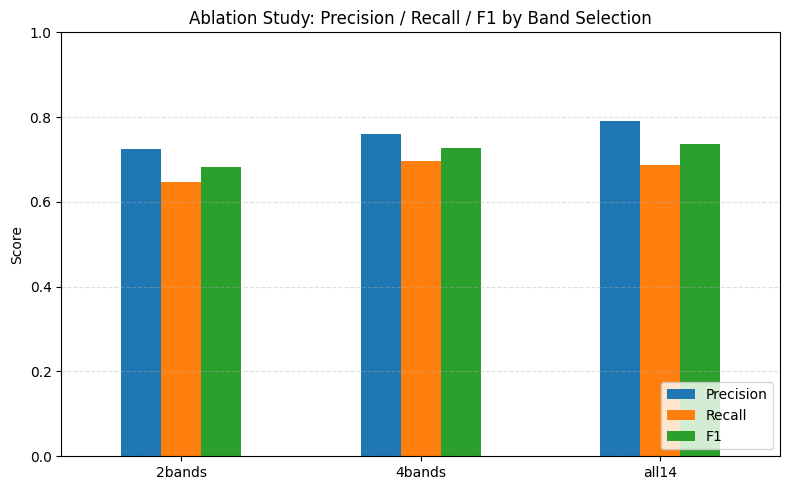

In [9]:
# Cell 6: Plotting the ablation results
import pandas as pd
import matplotlib.pyplot as plt

# results is the dict you filled above: { "2bands":(p,r,f), ... }
df = pd.DataFrame(results, index=['Precision','Recall','F1']).T
# e.g. df:
#           Precision    Recall      F1
# 2bands       0.72      0.68      0.70
# 4bands       0.75      0.71      0.73
# all14        0.78      0.74      0.76

ax = df.plot.bar(figsize=(8,5))
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Ablation Study: Precision / Recall / F1 by Band Selection')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()